# Introduction

## Short description of the problem

We have a torus of arbitrary (non-convex polygonal) cross-section.
We consider a semi-line (called LOS, for Line of Sight from now on) define by a starting point and a normalized vector.
We want to compute the intersections of that semi-line with the torus.

In particular, we want the first entry point inside the torus (PIn), the first exit point (POut), and for the exit point, we also want the index of the polygon (cross-section) segment on which it stands and the normalized vector to that segment at POut.
When the starting point already lies inside the torus, there is no PIn.

That computation should be done for a large number of LOS ($10^{5-6}$), and for cross-section polygons comprising 50-500 segments.

## Mathematical solutions and algorithm

The mathematical formulation can be found in , as well as all necessary derivations.
Here is a summary of the subsequent algorithm:

If $(O,\underline{e}_R,\underline{e}_{\phi},\underline{e}_Z)$ is a direct orthonormal cylindrical referential, to which the associated cartesian referential is $(O,\underline{e}_X,\underline{e}_Y,\underline{e}_Z)$, the inputs of the function are:

* Ds (3,Nl) np.ndarray of floats : an array containing the 3D (X,Y,Z) coordinates of the Nl starting points
* us (3,Nl) np.ndarray of floats : an array containing the 3D (X,Y,Z) coordinates of the Nl normalized vectors
* VPoly (2,Ns+1) np.ndarray of floats : an array containing the 2D (R,Z) coordinates of the Ns+1 points defining the Ns segments defining the cross-section polygon of the torus vessel
* VIn (2,Ns) np.ndarray of floats : an array containing the 2D (R,Z) coordinates of the Ns vectors perpendicular to the Ns segments and oriented inwards

For one LOS and one segment, let's find the parameter k such that $\underline{DM}=k\underline{u}$ where M is any intersection between the semi-line and the cone defined by the considered segment. If there are several intersections, their k values will be used to determine which ones are first along the line. To determine if an intersection is a PIn (entry) or a POut (exit), we compute the sign of the scalar product between $\underline{u}$ and the local normalized vector perpendicular to the segment and oriented inwards (entry=positive).

Then, introducing (see for details):
* $u_{ii,//}\cdot D_{ii,//} = us[0,ii]*Ds[0,ii]+us[1,ii]*Ds[1,ii]$
* $u_{ii,//}^2 = us[0,ii]^2+us[1,ii]^2$
* $D_{ii,//}^2 = Ds[0,ii]^2+Ds[1,ii]^2$

Then, the basic algorithm is, for each LOS defined by index ii (Ds[:,ii],us[:,ii]) and for any segment of index jj (VPoly[:,jj:jj+2]) is:

* if us[2,ii]==0, then, introducing:
   * $q = \frac{Ds[2,ii]-VPoly[1,jj]}{VPoly[1,jj+1]-VPoly[1,jj]}$ 
   * $C = q^2(VPoly[0,jj+1]-VPoly[0,jj])^2 + 2qVPoly[0,jj](VPoly[0,jj+1]-VPoly[0,jj]) + VPoly[0,jj]$

   There are solution only if:
      * VPoly[1,jj+1] != VPoly[1,jj]
      * $q \in [0;1[$
      * $\delta = (u_{ii,//}\cdot D_{ii,//})^2 - u_{ii,//}^2(D_{ii,//}^2-C) > 0$
   
   And the solutions are $k_{1,2} = \frac{-u_{ii,//}\cdot D_{ii,//} \pm \sqrt{\delta}}{u_{ii,//}^2}$ (valid only if $\geq0$, because semi-line)

* if us[2,ii]!=0, then, introducing:
   * $A = (VPoly[0,jj+1]-VPoly[0,jj])^2 - \frac{(VPoly[1,jj+1]-VPoly[1,jj])^2}{us[2,ii]^2}u_{ii,//}^2$
   * $B = VPoly[0,jj](VPoly[0,jj+1]-VPoly[0,jj]) + \frac{VPoly[1,jj+1]-VPoly[1,jj]}{us[2,ii]}\frac{Ds[2,ii]-VPoly[1,jj]}{us[2,ii]}u_{ii,//}^2 - \frac{VPoly[1,jj+1]-VPoly[1,jj]}{us[2,ii]}u_{ii,//}\cdot D_{ii,//}$
   * $C = -\left(\frac{Ds[2,ii]-VPoly[1,jj]}{us[2,ii]}\right)^2u_{ii,//}^2 + 2\frac{Ds[2,ii]-VPoly[1,jj]}{us[2,ii]}u_{ii,//}\cdot D_{ii,//} - D_{ii,//}^2 + VPoly[0,jj]^2$
   
   There are solution only if:
      * A = 0 and B != 0:
           * $q = -\frac{C}{2B}$ must be $\in [0;1[$
           * $k = q\frac{VPoly[1,jj+1]-VPoly[1,jj]}{us[2,ii]} - \frac{Ds[1,ii]-VPoly[1,jj]}{us[2,ii]}$ must be $\geq0$
      * A != 0:
           * $B^2$ must be > $AC$
           * $q_{1,2} = \frac{-B \pm \sqrt{B^2-AC}}{A}$ must be $\in [0;1[$
           * $k_{1,2} = q_{1,2}\frac{VPoly[1,jj+1]-VPoly[1,jj]}{us[2,ii]} - \frac{Ds[1,ii]-VPoly[1,jj]}{us[2,ii]}$ must be $\geq0$



### Safeguard

For solutions to be valid, they have to:
* lie on a given segment (cf.: $\in [0;1[$)
* lie on the semi-line (cf. $k\geq0$)
* In addition, they have to be located on the good side of the torus (no crossing through the center)

The first two conditions are met by the previous algorithm, the last one is enforced (on demand according to keyword argument Forbid) by excluding all solution in an angular sector opposite the sector the semi-line starting point.

In the following, in additon to the (Ds,us,VPoly,VIn) positional arguments, all functions also take a set of keyword arguments specifying in particular:
* Forbid=True (default)
* Margins and numeric tolerance values

# Function versions

In [1]:
import numpy as np

## Naive Python version with for loop

In [2]:
def Calc_LOS_PInOut_python(Ds, us, VPoly, vIn,
                           Forbid=True, RMin=None, EpsUz=1.e-9, EpsVz=1.e-9, EpsA=1.e-9, EpsB=1.e-9):
    
    ################
    # Prepare input
    RMin = 0.95*min(np.min(VPoly[0,:]),np.min(np.hypot(Ds[0,:],Ds[1,:]))) if RMin is None else RMin
    
    ################
    # Prepare output
    Nl, Ns = Ds.shape[1], vIn.shape[1]
    SIn, SOut = np.nan*np.ones((3,Nl),dtype=float), np.nan*np.ones((3,Nl),dtype=float)
    VPerp, indOut = np.nan*np.ones((3,Nl),dtype=float), np.nan*np.ones((Nl,),dtype=int)
    
    ################
    # Compute
    for ii in range(0,Nl):
        upscaDp = us[0,ii]*Ds[0,ii] + us[1,ii]*Ds[1,ii]
        upar2 = us[0,ii]**2 + us[1,ii]**2
        Dpar2 = Ds[0,ii]**2 + Ds[1,ii]**2
        # Prepare in case Forbid is True
        if Forbid:
            # Compute coordinates of the 2 points where the tangents touch the inner circle
            R2 = Ds[0,ii]**2 + Ds[1,ii]**2
            L = np.sqrt(R2-RMin**2)
            S1X = (RMin**2*Ds[0,ii]+RMin*Ds[1,ii]*L)/R2
            S1Y = (RMin**2*Ds[1,ii]-RMin*Ds[0,ii]*L)/R2
            S2X = (RMin**2*Ds[0,ii]-RMin*Ds[1,ii]*L)/R2
            S2Y = (RMin**2*Ds[1,ii]+RMin*Ds[0,ii]*L)/R2
        
        # Compute all solutions
        # Set tolerance value for us[2,ii]
        # EpsUz is the tolerated DZ across 50m (max Tokamak size)
        Crit = EpsUz*np.sqrt(upar2)/50.
        kout, kin, indout = np.inf, np.inf, None
        # Case with horizontal semi-line
        if np.abs(us[2,ii])<Crit:
            for jj in range(0,Ns):
                # Solutions exist only in the case with non-horizontal segment (i.e.: cone, not plane)
                if np.abs(vIn[1,jj])>EpsVz:
                    q = (Ds[2,ii]-VPoly[1,jj])/(VPoly[1,jj+1]-VPoly[1,jj])
                    # The intersection must stand on the segment 
                    if q>=0 and q<1:
                        C = q**2*(VPoly[0,jj+1]-VPoly[0,jj])**2 + 2.*q*VPoly[0,jj]*(VPoly[0,jj+1]-VPoly[0,jj]) + VPoly[0,jj]**2
                        delta = upscaDp**2 - upar2*(Dpar2-C)
                        if delta>0.:
                            sqd = np.sqrt(delta)
                            # The intersection must be on the semi-line (i.e.: k>=0)
                            # First solution
                            if -upscaDp - sqd >=0:
                                k = (-upscaDp - sqd)/upar2
                                sol = Ds[:,ii] + k*us[:,ii]
                                if Forbid:
                                    sca0 = (sol[0]-S1X)*Ds[0,ii] + (sol[1]-S1Y)*Ds[1,ii]
                                    sca1 = (sol[0]-S1X)*S1X + (sol[1]-S1Y)*S1Y
                                    sca2 = (sol[0]-S2X)*S2X + (sol[1]-S2Y)*S2Y
                                if not Forbid or (Forbid and not (sca0<0 and sca1<0 and sca2<0)):
                                    # Get the normalized perpendicular vector at intersection
                                    phi = np.arctan2(sol[1],sol[0])
                                    # Get the scalar product to determine entry or exit point
                                    sca = np.cos(phi)*vIn[0,jj]*us[0,ii] + np.sin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                                    if sca<=0 and k<kout:
                                        kout = k
                                        indout = jj
                                        #print 1, k
                                    elif sca>=0 and k<min(kin,kout):
                                        kin = k
                                        #print 2, k
                                    
                            # Second solution
                            if -upscaDp + sqd >=0:
                                k = (-upscaDp + sqd)/upar2
                                sol = Ds[:,ii] + k*us[:,ii]
                                if Forbid:
                                    sca0 = (sol[0]-S1X)*Ds[0,ii] + (sol[1]-S1Y)*Ds[1,ii]
                                    sca1 = (sol[0]-S1X)*S1X + (sol[1]-S1Y)*S1Y
                                    sca2 = (sol[0]-S2X)*S2X + (sol[1]-S2Y)*S2Y
                                if not Forbid or (Forbid and not (sca0<0 and sca1<0 and sca2<0)):
                                    # Get the normalized perpendicular vector at intersection
                                    phi = np.arctan2(sol[1],sol[0])
                                    # Get the scalar product to determine entry or exit point
                                    sca = np.cos(phi)*vIn[0,jj]*us[0,ii] + np.sin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                                    if sca<=0 and k<kout:
                                        kout = k
                                        indout = jj
                                        #print 3, k
                                    elif sca>=0 and k<min(kin,kout):
                                        kin = k
                                        #print 4, k
                                        
        # More general non-horizontal semi-line case
        else:
            for jj in range(Ns):
                v0, v1 = VPoly[0,jj+1]-VPoly[0,jj], VPoly[1,jj+1]-VPoly[1,jj]
                A = v0**2 - upar2*(v1/us[2,ii])**2
                B = VPoly[0,jj]*v0 + v1*(Ds[2,ii]-VPoly[1,jj])*upar2/us[2,ii]**2 - upscaDp*v1/us[2,ii]
                C = -upar2*(Ds[2,ii]-VPoly[1,jj])**2/us[2,ii]**2 + 2.*upscaDp*(Ds[2,ii]-VPoly[1,jj])/us[2,ii] - Dpar2 + VPoly[0,jj]**2              
               
                if np.abs(A)<EpsA and np.abs(B)>EpsB:
                    q = -C/(2.*B)
                    if q>=0. and q<1.:
                        k = (q*v1 - (Ds[2,ii]-VPoly[2,jj]))/us[2,ii]
                        if k>=0:
                            sol = Ds[:,ii] + k*us[:,ii]
                            if Forbid:
                                sca0 = (sol[0]-S1X)*Ds[0,ii] + (sol[1]-S1Y)*Ds[1,ii]
                                sca1 = (sol[0]-S1X)*S1X + (sol[1]-S1Y)*S1Y
                                sca2 = (sol[0]-S2X)*S2X + (sol[1]-S2Y)*S2Y
                                #print 1, k, kout, sca0, sca1, sca2
                                if sca0<0 and sca1<0 and sca2<0:
                                    continue
                            # Get the normalized perpendicular vector at intersection
                            phi = np.arctan2(sol[1],sol[0])
                            # Get the scalar product to determine entry or exit point
                            sca = np.cos(phi)*vIn[0,jj]*us[0,ii] + np.sin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                            if sca<=0 and k<kout:
                                kout = k
                                indout = jj
                                #print 5, k
                            elif sca>=0 and k<min(kin,kout):
                                kin = k
                                #print 6, k
                                
                elif np.abs(A)>EpsA and B**2>A*C:
                    sqd = np.sqrt(B**2-A*C)
                    # First solution
                    q = (-B + sqd)/A
                    if q>=0. and q<1.:
                        k = (q*v1 - (Ds[2,ii]-VPoly[1,jj]))/us[2,ii]
                        if k>=0.:
                            sol = Ds[:,ii] + k*us[:,ii]
                            if Forbid:
                                sca0 = (sol[0]-S1X)*Ds[0,ii] + (sol[1]-S1Y)*Ds[1,ii]
                                sca1 = (sol[0]-S1X)*S1X + (sol[1]-S1Y)*S1Y
                                sca2 = (sol[0]-S2X)*S2X + (sol[1]-S2Y)*S2Y
                                #print 2, k, kout, sca0, sca1, sca2
                            if not Forbid or (Forbid and not (sca0<0 and sca1<0 and sca2<0)):
                                # Get the normalized perpendicular vector at intersection
                                phi = np.arctan2(sol[1],sol[0])
                                # Get the scalar product to determine entry or exit point
                                sca = np.cos(phi)*vIn[0,jj]*us[0,ii] + np.sin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                                if sca<=0 and k<kout:
                                    kout = k
                                    indout = jj
                                    #print 7, k, q, A, B, C, sqd
                                elif sca>=0 and k<min(kin,kout):
                                    kin = k
                                    #print 8, k, jj
                            
                    # Second solution
                    q = (-B - sqd)/A
                    if q>=0. and q<1.:
                        k = (q*v1 - (Ds[2,ii]-VPoly[1,jj]))/us[2,ii]
                        
                        if k>=0.:
                            sol = Ds[:,ii] + k*us[:,ii]
                            if Forbid:
                                sca0 = (sol[0]-S1X)*Ds[0,ii] + (sol[1]-S1Y)*Ds[1,ii]
                                sca1 = (sol[0]-S1X)*S1X + (sol[1]-S1Y)*S1Y
                                sca2 = (sol[0]-S2X)*S2X + (sol[1]-S2Y)*S2Y
                                #print 3, k, kout, sca0, sca1, sca2
                            if not Forbid or (Forbid and not (sca0<0 and sca1<0 and sca2<0)):
                                # Get the normalized perpendicular vector at intersection
                                phi = np.arctan2(sol[1],sol[0])
                                # Get the scalar product to determine entry or exit point
                                sca = np.cos(phi)*vIn[0,jj]*us[0,ii] + np.sin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                                if sca<=0 and k<kout:
                                    kout = k
                                    indout = jj
                                    #print 9, k, jj
                                elif sca>=0 and k<min(kin,kout):
                                    kin = k
                                    #print 10, k, q, A, B, C, sqd, v0, v1, jj

        if indout is not None:
            indOut[ii] = indout
            SOut[:,ii] = Ds[:,ii] + kout*us[:,ii]
            phi = np.arctan2(SOut[1,ii],SOut[0,ii])
            VPerp[:,ii] = np.cos(phi)*vIn[0,indout], np.sin(phi)*vIn[0,indout], vIn[1,indout]
        if kin<kout:
            SIn[:,ii] = Ds[:,ii] + kin*us[:,ii]
    return SIn, SOut, VPerp, indOut


## Numpy version

In [3]:
import numpy as np
def Calc_LOS_PInOut_numpy1(Ds, us, VPoly, vIn,
                          Forbid=True, RMin=None, EpsUz=1.e-6, EpsVz=1.e-9, EpsA=1.e-9, EpsB=1.e-9):

    # Prepare inputs
    RMin = 0.95*min(np.min(VPoly[0,:]),np.min(np.hypot(Ds[0,:],Ds[1,:]))) if RMin is None else RMin
    
    # Pre-define useful quantities
    Cs = VPoly[:,:-1]
    vs = VPoly[:,1:]-VPoly[:,:-1]
    upscaDp = us[0,:]*Ds[0,:] + us[1,:]*Ds[1,:]
    upar2 = us[0,:]**2 + us[1,:]**2
    Dpar2 = Ds[0,:]**2 + Ds[1,:]**2
    MaxErr = 20.
    NL, NS = Ds.shape[1], vIn.shape[1]

    Ds0, Ds1, Ds2 = np.tile(Ds[0,:],(NS,1)).T, np.tile(Ds[1,:],(NS,1)).T, np.tile(Ds[2,:],(NS,1)).T
    us0, us1, us2 = np.tile(us[0,:],(NS,1)).T, np.tile(us[1,:],(NS,1)).T, np.tile(us[2,:],(NS,1)).T
    Cs0, Cs1 = np.tile(Cs[0,:],(NL,1)), np.tile(Cs[1,:],(NL,1))
    vs0, vs1 = np.tile(vs[0,:],(NL,1)), np.tile(vs[1,:],(NL,1))
    upscaDpF = np.tile(upscaDp,(NS,1)).T
    upar2F = np.tile(upar2,(NS,1)).T
    Dpar2F = np.tile(Dpar2,(NS,1)).T

    ########################
    # Find all intersections
    # 1st dim = LOS
    # 2nd dim = VPoly
    ########################

    ###########################
    # Start with horizontal LOS

    # Prepare arrays
    # q, sqd = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
    sqd = np.nan*np.ones((NL,NS))   # Test
    k0, k1 = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
    
    Crit = EpsUz*np.sqrt(upar2F)/MaxErr
    # Compute quasi-horizontal LOS
    ind01 = np.abs(us2) < Crit      # Consider quasi-horizontal cases to avoid near-zero divisions otherwise, EpsUz is the tolerated DZ across 50m (max Tokamak size)
    ind01[ind01] = np.abs(vs1[ind01])>EpsVz
    q = (Ds2[ind01]-Cs1[ind01])/vs1[ind01]
    ii = (q>=0) & (q<1)
    ind01[ind01], q = ii, q[ii]
    C = q**2*vs0[ind01]**2 + 2.*q*Cs0[ind01]*vs0[ind01] + Cs0[ind01]**2
    delta = upscaDpF[ind01]**2 - upar2F[ind01]*(Dpar2F[ind01]-C)
    ind01[ind01] = delta>0.
    sqd[ind01] = np.sqrt(delta)
    ind02 = np.copy(ind01)
    ind01[ind01] = (-upscaDpF[ind01] - sqd[ind01]) >= 0.
    ind02[ind02] = (-upscaDpF[ind02] + sqd[ind02]) >= 0.
    k0[ind01] = (-upscaDpF[ind01] - sqd[ind01])/upar2F[ind01]
    k1[ind02] = (-upscaDpF[ind02] + sqd[ind02])/upar2F[ind02]
    print 'A',k0[ind01], np.any(ind01,axis=0).nonzero()[0], q, C, sqd[ind01]
    print 'A',k1[ind02], np.any(ind02,axis=0).nonzero()[0], q
    del q, C, delta, sqd
    
    # Prepare quantities for general cases
    q, q1, q2 = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
    # Compute general cases
    Au2 = vs0**2*us2**2 - upar2F*vs1**2
    Bu2 = Cs0*vs0*us2**2 + vs1*(Ds2-Cs1)*upar2F - upscaDpF*vs1*us2
    Cu2 = -upar2F*(Ds2-Cs1)**2 + 2.*upscaDpF*(Ds2-Cs1)*us2 + (Cs0**2 - Dpar2F)*us2**2

    ind1 = (np.abs(us2) >= Crit) & (np.abs(Au2)<EpsA*us2**2) & (np.abs(Bu2)>EpsB*us2**2)
    q[ind1] = -Cu2[ind1]/(2.*Bu2[ind1])
    ind1[ind1] = (q[ind1]>=0) & (q[ind1]<1)
    kk = (q[ind1]*vs1[ind1] - (Ds2[ind1]-Cs1[ind1]))/us2[ind1]
    ind1[ind1] = kk>=0.
    k0[ind1] = kk[kk>=0.]
    print 'B',k0[ind1], q[ind1]
    del q, kk, upscaDpF, upar2F, Dpar2F
    
    ind21 = (np.abs(us2) >= Crit) & (np.abs(Au2)>=EpsA*us2**2) & (Bu2**2>Au2*Cu2)
    sqd = np.sqrt(Bu2[ind21]**2-Au2[ind21]*Cu2[ind21])
    q1[ind21] = (-Bu2[ind21] + sqd)/Au2[ind21]
    q2[ind21] = (-Bu2[ind21] - sqd)/Au2[ind21]
    ind22 = np.copy(ind21)
    ind21[ind21] = (q1[ind21]>=0) & (q1[ind21]<1.)
    ind22[ind22] = (q2[ind22]>=0) & (q2[ind22]<1.)
    kk0 = (q1[ind21]*vs1[ind21] - (Ds2[ind21]-Cs1[ind21]))/us2[ind21]
    kk1 = (q2[ind22]*vs1[ind22] - (Ds2[ind22]-Cs1[ind22]))/us2[ind22]
    ind21[ind21] = kk0>=0.
    ind22[ind22] = kk1>=0.
    k0[ind21] = kk0[kk0>=0.]
    k1[ind22] = kk1[kk1>=0.]
    print 'C',k0[ind21], q1[ind21], Au2[ind21], Bu2[ind21], Cu2[ind21]
    print 'C',k1[ind22], q2[ind22], Au2[ind22], Bu2[ind22], Cu2[ind22]
    del Au2, Bu2, Cu2, sqd, q1, q2, kk0, kk1, Cs0, Cs1, vs0, vs1

    # Compute associated solutions
    S00, S01, S02 = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
    S10, S11, S12 = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
    Ind1, Ind2 = [ind01,ind1,ind21], [ind02,ind22]
    for ii in range(0,len(Ind1)):
        S00[Ind1[ii]] = Ds0[Ind1[ii]] + k0[Ind1[ii]]*us0[Ind1[ii]]
        S01[Ind1[ii]] = Ds1[Ind1[ii]] + k0[Ind1[ii]]*us1[Ind1[ii]]
        S02[Ind1[ii]] = Ds2[Ind1[ii]] + k0[Ind1[ii]]*us2[Ind1[ii]]
    for ii in range(0,len(Ind2)):
        S10[Ind2[ii]] = Ds0[Ind2[ii]] + k1[Ind2[ii]]*us0[Ind2[ii]]
        S11[Ind2[ii]] = Ds1[Ind2[ii]] + k1[Ind2[ii]]*us1[Ind2[ii]]
        S12[Ind2[ii]] = Ds2[Ind2[ii]] + k1[Ind2[ii]]*us2[Ind2[ii]]
    Ind0 = ind01 | ind1 | ind21
    Ind1 = ind02 | ind22
    del ind01, ind1, ind21, ind02, ind22

    # Eliminate solution in forbidden area

    RMin = 0.95*min(np.nanmin(VPoly[0,:]), np.nanmin(np.hypot(Ds[0,:],Ds[1,:]))) if RMin is None else RMin
    RMax = 1.05*np.nanmax(VPoly[0,:])
    ZMin, ZMax = np.nanmin(VPoly[1,:])-0.05*np.abs(np.nanmin(VPoly[1,:])), np.nanmax(VPoly[1,:])+0.05*np.abs(np.nanmax(VPoly[1,:]))
    RS0, RS1 = np.hypot(S00,S01), np.hypot(S10,S11)
    iin0, iin1 = ~np.isnan(RS0), ~np.isnan(RS1)
    RS0, RS1 = RS0[iin0], RS1[iin1]
    
    inderr0 = (RS0<RMin) | (RS0>RMax)
    inderr1 = (RS1<RMin) | (RS1>RMax)
    assert inderr0.sum()==0 and inderr1.sum()==0, "Some solutions ({0} in S0 and {1} in S1) are way too far({2})/close({3}) !".format(inderr0.sum(),inderr1.sum(),RMax,RMin)+str(RS0)+" "+str(RS1)+"  "+str(k0[Ind0n])+"  "+str(k1[Ind1n])
    inderr0 = (S02<ZMin) | (S02>ZMax)
    inderr1 = (S12<ZMin) | (S12>ZMax)
    assert inderr0.sum()==0 and inderr1.sum()==0, "Some solutions ({0} in S0 and {1} in S1) are way too high({0})/low({1}) !".format(inderr0.sum(),inderr1.sum(),ZMax,ZMin)+str(S0[2,:])+"  "+str(S1[2,:])
    
    if Forbid:
        # This criterion is the same for both solution k0 and k1
        Ind = Ind0 | Ind1
        # Prepare useful quantities
        R2, L = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
        S1X, S1Y = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
        S2X, S2Y = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
        # Add a little bit of margin to the major radius, just in case
        R2[Ind] = Ds0[Ind]**2+Ds1[Ind]**2
        L[Ind] = np.sqrt(R2[Ind]-RMin**2)
        # Compute coordinates of the 2 points where the tangents touch the inner circle
        S1X[Ind] = (RMin**2*Ds0[Ind]+RMin*Ds1[Ind]*L[Ind])/R2[Ind]
        S1Y[Ind] = (RMin**2*Ds1[Ind]-RMin*Ds0[Ind]*L[Ind])/R2[Ind]
        S2X[Ind] = (RMin**2*Ds0[Ind]-RMin*Ds1[Ind]*L[Ind])/R2[Ind]
        S2Y[Ind] = (RMin**2*Ds1[Ind]+RMin*Ds0[Ind]*L[Ind])/R2[Ind]
        # Check solutiona are on the good side of the 3 planes
        indout = (S00[Ind0]-S1X[Ind0])*Ds0[Ind0] + (S01[Ind0]-S1Y[Ind0])*Ds1[Ind0] < 0.
        indout = indout & ((S00[Ind0]-S1X[Ind0])*S1X[Ind0] + (S01[Ind0]-S1Y[Ind0])*S1Y[Ind0] < 0.)
        indout = indout & ((S00[Ind0]-S2X[Ind0])*S2X[Ind0] + (S01[Ind0]-S2Y[Ind0])*S2Y[Ind0] < 0.)
        Ind0[Ind0] = ~indout
        indout = (S10[Ind1]-S1X[Ind1])*Ds0[Ind1] + (S11[Ind1]-S1Y[Ind1])*Ds1[Ind1] < 0.
        indout = indout & ((S10[Ind1]-S1X[Ind1])*S1X[Ind1] + (S11[Ind1]-S1Y[Ind1])*S1Y[Ind1] < 0.)
        indout = indout & ((S10[Ind1]-S2X[Ind1])*S2X[Ind1] + (S11[Ind1]-S2Y[Ind1])*S2Y[Ind1] < 0.)
        Ind1[Ind1] = ~indout
        del Ind, R2, L, S1X, S1Y, S2X, S2Y, indout

    # Identify the POut (if any) and PIn (if any)
    VIn0, VIn1 = np.tile(vIn[0,:],(NL,1)), np.tile(vIn[1,:],(NL,1))

    sca0, sca1 = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
    sca0[Ind0] = us0[Ind0]*VIn0[Ind0]*np.cos(np.arctan2(S01[Ind0],S00[Ind0])) + us1[Ind0]*VIn0[Ind0]*np.sin(np.arctan2(S01[Ind0],S00[Ind0])) + us2[Ind0]*VIn1[Ind0]
    sca1[Ind1] = us0[Ind1]*VIn0[Ind1]*np.cos(np.arctan2(S11[Ind1],S10[Ind1])) + us1[Ind1]*VIn0[Ind1]*np.sin(np.arctan2(S11[Ind1],S10[Ind1])) + us2[Ind1]*VIn1[Ind1]
    ind0out, ind1out = np.copy(Ind0), np.copy(Ind1)
    ind0out[ind0out] = sca0[ind0out]<0.
    ind1out[ind1out] = sca1[ind1out]<0.
    kk0, kk1 = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
    kk0[ind0out], kk1[ind1out] = k0[ind0out], k1[ind1out]
    kk = np.fmin(kk0,kk1)
    kout = np.nanmin(kk,axis=1)
    SOut = Ds + kout[np.newaxis,:]*us
    indOut = np.nan*np.ones((NL,))
    indok = ~np.isnan(kout)
    indOut[indok] = np.nanargmin(kk[indok,:],axis=1)
    phi = np.arctan2(SOut[1,indok],SOut[0,indok])
    VPerp = np.nan*np.ones((3,NL),dtype=float)
    VPerp[:,indok] = np.array([np.cos(phi)*vIn[0,indOut[indok].astype(int)], np.sin(phi)*vIn[0,indOut[indok].astype(int)], vIn[1,indOut[indok].astype(int)]])
    
    ind0in, ind1in = np.copy(Ind0), np.copy(Ind1)
    ind0in[ind0in] = sca0[ind0in]>0.
    ind1in[ind1in] = sca1[ind1in]>0.
    ind0in[ind0in] = k0[ind0in] < (np.tile(kout,(NS,1)).T)[ind0in]
    ind1in[ind1in] = k1[ind1in] < (np.tile(kout,(NS,1)).T)[ind1in]
    kk0, kk1 = np.nan*np.ones((NL,NS)), np.nan*np.ones((NL,NS))
    kk0[ind0in], kk1[ind1in] = k0[ind0in], k1[ind1in]
    kk = np.fmin(kk0,kk1)
    SIn = Ds + np.nanmin(kk,axis=1)[np.newaxis,:]*us
    
    return SIn, SOut, VPerp, indOut
    

## Cython version

In [4]:
%load_ext cython

In [5]:
%%cython -a
cimport cython
import numpy as np
cimport numpy as cnp
import math
from cpython cimport bool
from libc.math cimport sqrt as Csqrt, cos as Ccos, sin as Csin, atan2 as Catan2

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def Calc_LOS_PInOut_cython(double [:,::1] Ds, double [:,::1] us, double [:,::1] VPoly, double [:,::1] vIn,
                           bool Forbid=True, RMin=None, double EpsUz=1.e-6, double EpsVz=1.e-9, double EpsA=1.e-9, double EpsB=1.e-9):

    cdef int ii, jj, Nl=Ds.shape[1], Ns=vIn.shape[1]
    cdef double Rmin, upscaDp, upar2, Dpar2, Crit2, kout, kin
    cdef int indout, Done
    cdef double L, S1X, S1Y, S2X, S2Y, sca, sca0, sca1, sca2
    cdef double q, C, delta, sqd, k, sol0, sol1
    cdef double v0, v1, A, B
    cdef int Forbidbis, Forbid0
    cdef cnp.ndarray[double,ndim=2] SIn_=np.nan*np.ones((3,Nl)), SOut_=np.nan*np.ones((3,Nl))
    cdef cnp.ndarray[double,ndim=2] VPerp_=np.nan*np.ones((3,Nl))
    cdef cnp.ndarray[double,ndim=1] indOut_=np.nan*np.ones((Nl,))

    cdef double[:,::1] SIn=SIn_, SOut=SOut_, VPerp=VPerp_
    cdef double[::1] indOut=indOut_
    
    ################
    # Prepare input
    if RMin is None:
        Rmin = 0.95*min(np.min(VPoly[0,:]),np.min(np.hypot(Ds[0,:],Ds[1,:])))
    else:
        Rmin = RMin
    
    ################
    # Compute
    if Forbid:
        Forbid0, Forbidbis = 1, 1
    else:
        Forbid0, Forbidbis = 0, 0
    for ii in range(0,Nl):
        upscaDp = us[0,ii]*Ds[0,ii] + us[1,ii]*Ds[1,ii]
        upar2 = us[0,ii]**2 + us[1,ii]**2
        Dpar2 = Ds[0,ii]**2 + Ds[1,ii]**2
        # Prepare in case Forbid is True
        if Forbid0 and not Dpar2>0:
            Forbidbis = 0
        if Forbidbis:
            # Compute coordinates of the 2 points where the tangents touch the inner circle
            L = Csqrt(Dpar2-Rmin**2)
            S1X = (Rmin**2*Ds[0,ii]+Rmin*Ds[1,ii]*L)/Dpar2
            S1Y = (Rmin**2*Ds[1,ii]-Rmin*Ds[0,ii]*L)/Dpar2
            S2X = (Rmin**2*Ds[0,ii]-Rmin*Ds[1,ii]*L)/Dpar2
            S2Y = (Rmin**2*Ds[1,ii]+Rmin*Ds[0,ii]*L)/Dpar2
        
        # Compute all solutions
        # Set tolerance value for us[2,ii]
        # EpsUz is the tolerated DZ across 20m (max Tokamak size)
        Crit2 = EpsUz**2*upar2/400.
        kout, kin, Done = 1.e12, 1e12, 0
        # Case with horizontal semi-line
        if us[2,ii]**2<Crit2:
            for jj in range(0,Ns):
                # Solutions exist only in the case with non-horizontal segment (i.e.: cone, not plane)
                if (VPoly[1,jj+1]-VPoly[1,jj])**2>EpsVz**2:
                    q = (Ds[2,ii]-VPoly[1,jj])/(VPoly[1,jj+1]-VPoly[1,jj])
                    # The intersection must stand on the segment 
                    if q>=0 and q<1:
                        C = q**2*(VPoly[0,jj+1]-VPoly[0,jj])**2 + 2.*q*VPoly[0,jj]*(VPoly[0,jj+1]-VPoly[0,jj]) + VPoly[0,jj]**2
                        delta = upscaDp**2 - upar2*(Dpar2-C)
                        if delta>0.:
                            sqd = Csqrt(delta)
                            # The intersection must be on the semi-line (i.e.: k>=0)
                            # First solution
                            if -upscaDp - sqd >=0:
                                k = (-upscaDp - sqd)/upar2
                                sol0, sol1 = Ds[0,ii] + k*us[0,ii], Ds[1,ii] + k*us[1,ii] 
                                if Forbidbis:
                                    sca0 = (sol0-S1X)*Ds[0,ii] + (sol1-S1Y)*Ds[1,ii]
                                    sca1 = (sol0-S1X)*S1X + (sol1-S1Y)*S1Y
                                    sca2 = (sol0-S2X)*S2X + (sol1-S2Y)*S2Y
                                if not Forbidbis or (Forbidbis and not (sca0<0 and sca1<0 and sca2<0)):
                                    # Get the normalized perpendicular vector at intersection
                                    phi = Catan2(sol1,sol0)
                                    # Get the scalar product to determine entry or exit point
                                    sca = Ccos(phi)*vIn[0,jj]*us[0,ii] + Csin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                                    if sca<=0 and k<kout:
                                        kout = k
                                        indout = jj
                                        Done = 1
                                        print 1, k
                                    elif sca>=0 and k<min(kin,kout):
                                        kin = k
                                        print 2, k
                                    
                            # Second solution
                            if -upscaDp + sqd >=0:
                                k = (-upscaDp + sqd)/upar2
                                sol0, sol1 = Ds[0,ii] + k*us[0,ii], Ds[1,ii] + k*us[1,ii]
                                if Forbidbis:
                                    sca0 = (sol0-S1X)*Ds[0,ii] + (sol1-S1Y)*Ds[1,ii]
                                    sca1 = (sol0-S1X)*S1X + (sol1-S1Y)*S1Y
                                    sca2 = (sol0-S2X)*S2X + (sol1-S2Y)*S2Y
                                if not Forbidbis or (Forbidbis and not (sca0<0 and sca1<0 and sca2<0)):
                                    # Get the normalized perpendicular vector at intersection
                                    phi = Catan2(sol1,sol0)
                                    # Get the scalar product to determine entry or exit point
                                    sca = Ccos(phi)*vIn[0,jj]*us[0,ii] + Csin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                                    if sca<=0 and k<kout:
                                        kout = k
                                        indout = jj
                                        Done = 1
                                        print 3, k
                                    elif sca>=0 and k<min(kin,kout):
                                        kin = k
                                        print 4, k
                                        
        # More general non-horizontal semi-line case
        else:
            for jj in range(Ns):
                v0, v1 = VPoly[0,jj+1]-VPoly[0,jj], VPoly[1,jj+1]-VPoly[1,jj]
                A = v0**2 - upar2*(v1/us[2,ii])**2
                B = VPoly[0,jj]*v0 + v1*(Ds[2,ii]-VPoly[1,jj])*upar2/us[2,ii]**2 - upscaDp*v1/us[2,ii]
                C = -upar2*(Ds[2,ii]-VPoly[1,jj])**2/us[2,ii]**2 + 2.*upscaDp*(Ds[2,ii]-VPoly[1,jj])/us[2,ii] - Dpar2 + VPoly[0,jj]**2              
               
                if A**2<EpsA**2 and B**2>EpsB**2:
                    q = -C/(2.*B)
                    if q>=0. and q<1.:
                        k = (q*v1 - (Ds[2,ii]-VPoly[2,jj]))/us[2,ii]
                        if k>=0:
                            sol0, sol1 = Ds[0,ii] + k*us[0,ii], Ds[1,ii] + k*us[1,ii]
                            if Forbidbis:
                                sca0 = (sol0-S1X)*Ds[0,ii] + (sol1-S1Y)*Ds[1,ii]
                                sca1 = (sol0-S1X)*S1X + (sol1-S1Y)*S1Y
                                sca2 = (sol0-S2X)*S2X + (sol1-S2Y)*S2Y
                                #print 1, k, kout, sca0, sca1, sca2
                                if sca0<0 and sca1<0 and sca2<0:
                                    continue
                            # Get the normalized perpendicular vector at intersection
                            phi = Catan2(sol1,sol0)
                            # Get the scalar product to determine entry or exit point
                            sca = Ccos(phi)*vIn[0,jj]*us[0,ii] + Csin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                            if sca<=0 and k<kout:
                                kout = k
                                indout = jj
                                Done = 1
                                print 5, k
                            elif sca>=0 and k<min(kin,kout):
                                kin = k
                                print 6, k
                                
                elif A**2>=EpsA**2 and B**2>A*C:
                    sqd = Csqrt(B**2-A*C)
                    # First solution
                    q = (-B + sqd)/A
                    if q>=0. and q<1.:
                        k = (q*v1 - (Ds[2,ii]-VPoly[1,jj]))/us[2,ii]
                        if k>=0.:
                            sol0, sol1 = Ds[0,ii] + k*us[0,ii], Ds[1,ii] + k*us[1,ii]
                            if Forbidbis:
                                sca0 = (sol0-S1X)*Ds[0,ii] + (sol1-S1Y)*Ds[1,ii]
                                sca1 = (sol0-S1X)*S1X + (sol1-S1Y)*S1Y
                                sca2 = (sol0-S2X)*S2X + (sol1-S2Y)*S2Y
                                #print 2, k, kout, sca0, sca1, sca2
                            if not Forbidbis or (Forbidbis and not (sca0<0 and sca1<0 and sca2<0)):
                                # Get the normalized perpendicular vector at intersection
                                phi = Catan2(sol1,sol0)
                                # Get the scalar product to determine entry or exit point
                                sca = Ccos(phi)*vIn[0,jj]*us[0,ii] + Csin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                                if sca<=0 and k<kout:
                                    kout = k
                                    indout = jj
                                    Done = 1
                                    print 7, k, q, A, B, C, sqd
                                elif sca>=0 and k<min(kin,kout):
                                    kin = k
                                    print 8, k, jj
                            
                    # Second solution
                    q = (-B - sqd)/A
                    if q>=0. and q<1.:
                        k = (q*v1 - (Ds[2,ii]-VPoly[1,jj]))/us[2,ii]
                        
                        if k>=0.:
                            sol0, sol1 = Ds[0,ii] + k*us[0,ii], Ds[1,ii] + k*us[1,ii]
                            if Forbidbis:
                                sca0 = (sol0-S1X)*Ds[0,ii] + (sol1-S1Y)*Ds[1,ii]
                                sca1 = (sol0-S1X)*S1X + (sol1-S1Y)*S1Y
                                sca2 = (sol0-S2X)*S2X + (sol1-S2Y)*S2Y
                                #print 3, k, kout, sca0, sca1, sca2
                            if not Forbidbis or (Forbidbis and not (sca0<0 and sca1<0 and sca2<0)):
                                # Get the normalized perpendicular vector at intersection
                                phi = Catan2(sol1,sol0)
                                # Get the scalar product to determine entry or exit point
                                sca = Ccos(phi)*vIn[0,jj]*us[0,ii] + Csin(phi)*vIn[0,jj]*us[1,ii] + vIn[1,jj]*us[2,ii]
                                if sca<=0 and k<kout:
                                    kout = k
                                    indout = jj
                                    Done = 1
                                    print 9, k, jj
                                elif sca>=0 and k<min(kin,kout):
                                    kin = k
                                    print 10, k, q, A, B, C, sqd, v0, v1, jj

        if Done==1:
            indOut[ii] = indout
            SOut[0,ii] = Ds[0,ii] + kout*us[0,ii]
            SOut[1,ii] = Ds[1,ii] + kout*us[1,ii]
            SOut[2,ii] = Ds[2,ii] + kout*us[2,ii]
            phi = Catan2(SOut[1,ii],SOut[0,ii])
            VPerp[0,ii] = Ccos(phi)*vIn[0,indout]
            VPerp[1,ii] = Csin(phi)*vIn[0,indout]
            VPerp[2,ii] = vIn[1,indout]
        if kin<kout:
            SIn[0,ii] = Ds[0,ii] + kin*us[0,ii]
            SIn[1,ii] = Ds[1,ii] + kin*us[1,ii]
            SIn[2,ii] = Ds[2,ii] + kin*us[2,ii]
            

    return np.asarray(SIn), np.asarray(SOut), np.asarray(VPerp), np.asarray(indOut)


## Pythran version

## Numba version

# Benchmark overview

## Test data

In [9]:
# Useful functions for defining input data

C, a = [3.,0.], 1.
def makeVesPoly(NS, C=C, a=a):
    theta = np.linspace(0,2.*np.pi,NS+1)
    VP = np.array([C[0]+a*np.cos(theta), C[1]+a*np.sin(theta)])
    ind = (VP[1,:]<C[1]-0.85*a).nonzero()[0]
    div = np.array([[C[0]-0.2*a, C[0], C[0]+0.2*a],[C[1]-1.2*a, C[1]-0.75*a, C[1]-1.2*a]])
    VP = np.concatenate((VP[:,:ind[0]],div,VP[:,ind[-1]+1:-1],VP[:,0:1]), axis=1)
    return VP

phi = [0.,np.pi/3.,np.pi/2.,np.pi]
Dr = [-0.1,0.1]
def makeLOS(NL, phi=phi, theta=phi, Dr=Dr, dphi=0., Dthet=np.pi/2., C=C, a=a):
    Ntot = len(phi)*len(theta)*len(Dr)
    nn = np.ceil(Ntot/NL)
    Ds, us = [], []
    for ii in range(len(Dr)):
        for jj in range(len(phi)):
            for kk in range(len(theta)):
                D = np.array([(C[0]+(a+Dr[ii])*np.cos(theta[kk]))*np.cos(phi[jj]), (C[0]+(a+Dr[ii])*np.cos(theta[kk]))*np.sin(phi[jj]), C[1]+(a+Dr[ii])*np.sin(theta[kk])])
                Ref = np.array([C[0]*np.cos(phi[jj]), C[0]*np.sin(phi[jj]), C[1]])
                duRef = (Ref-D)/np.linalg.norm(Ref-D)
                if NL==1:
                    dus = duRef.reshape((3,1))
                else:
                    ephi = np.array([-np.sin(phi[jj]),np.cos(phi[jj]),0.])
                    eperp = np.cross(ephi,duRef)/np.linalg.norm(np.cross(ephi,duRef))
                    epar = duRef*np.cos(dphi) + ephi*np.sin(dphi)
                    DThet = np.linspace(-Dthet,Dthet,NL)[np.newaxis,:]
                    dus = epar[:,np.newaxis]*np.cos(DThet) + eperp[:,np.newaxis]*np.sin(DThet)
                    dus = np.concatenate((duRef.reshape((3,1)),dus),axis=1)
                dus = dus/(np.sqrt(np.sum(dus**2,axis=0))[np.newaxis,:])
                Ds.append(np.tile(D,(dus.shape[1],1)).T)
                us.append(dus)
    Ds = np.concatenate(tuple(Ds),axis=1)
    us = np.concatenate(tuple(us),axis=1)
    return Ds, us

                



## Results 

### Preliminary checks and debugging

In [12]:
VPoly = makeVesPoly(50)
vIn = np.array([-(VPoly[1,1:]-VPoly[1,:-1]), VPoly[0,1:]-VPoly[0,:-1]])
vIn = vIn/np.tile(np.sqrt(np.sum(vIn**2,axis=0)),(2,1))
Ds, us = makeLOS(100)

N, nN = 0, Ds.shape[1]
SIn0, SOut0, VPerp0, indOut0 = Calc_LOS_PInOut_python(Ds[:,N:N+nN], us[:,N:N+nN], VPoly, vIn, Forbid=True)#[:,N:N+nN]
SIn1, SOut1, VPerp1, indOut1 = Calc_LOS_PInOut_numpy1(Ds[:,N:N+nN], us[:,N:N+nN], VPoly, vIn, Forbid=True)

/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in divide
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in divide
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in divide
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in divide
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in subtract
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: divide by zero encountered in divide
/Applications/Anacon

In [13]:
print np.allclose(SIn0, SIn1,atol=1.e-9,rtol=0., equal_nan=True)
print np.allclose(SOut0, SOut1,atol=1.e-9,rtol=0., equal_nan=True)
print np.allclose(VPerp0, VPerp1,atol=1.e-9,rtol=0., equal_nan=True)
print np.allclose(indOut0, indOut1,atol=1.e-9,rtol=0., equal_nan=True)

True
True
True
True


In [14]:
d = np.sqrt(np.sum((SIn0-SIn1)**2,axis=0))
print np.nanmax(d), (d>0.1*np.nanmax(d)).nonzero()[0]
print (np.any(np.isnan(SOut0),axis=0) & np.all(~np.isnan(SOut1),axis=0)).nonzero()[0]
print (np.any(np.isnan(SOut1),axis=0) & np.all(~np.isnan(SOut0),axis=0)).nonzero()[0]
print (np.any(np.isnan(SIn0),axis=0) & np.all(~np.isnan(SIn1),axis=0)).nonzero()[0]
print (np.any(np.isnan(SIn1),axis=0) & np.all(~np.isnan(SIn0),axis=0)).nonzero()[0]
print (np.sqrt(np.sum((SOut0-SOut1)**2,axis=0))>1.e-9).nonzero()[0]
print (np.sqrt(np.sum((SIn0-SIn1)**2,axis=0))>1.e-9).nonzero()[0]

0.0 []
[]
[]
[]
[]
[]
[]


/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


### Benchmark


LS = 50
    LL = 1
        python 0.0191445 / 0.000610945010255
        cython 0.000199 / 4.98820831785e-05   True vs python
        numpy1 0.003128 / 0.0014264099068   True vs cython
    LL = 4


/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in divide
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in divide
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in divide
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in divide
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in subtract
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: divide by zero encountered in divide
/Applications/Anacon

        python 0.122824 / 0.0189960652124
        cython 0.000407 / 5.26743137908e-05   True vs python
        numpy1 0.0062755 / 0.000329268591815   True vs cython
    LL = 10
        python 0.284569 / 0.00505746370614
        cython 0.0007995 / 0.000143224765084   True vs python
        numpy1 0.012043 / 0.000852165216115   True vs cython
    LL = 40
        python 1.1191715 / 0.00588616891299
        cython 0.002464 / 0.000253885418163   True vs python
        numpy1 0.043131 / 0.00111199696492   True vs cython
    LL = 100
        python 2.7928785 / 0.00647867684536
        cython 0.005834 / 0.000253289963393   True vs python
        numpy1 0.1099845 / 0.00597864986849   True vs cython
    LL = 400
        python 11.084091 / 0.0302316658347
        cython 0.022572 / 0.000288738299426   True vs python
        numpy1 0.4673885 / 0.0165061515949   True vs cython


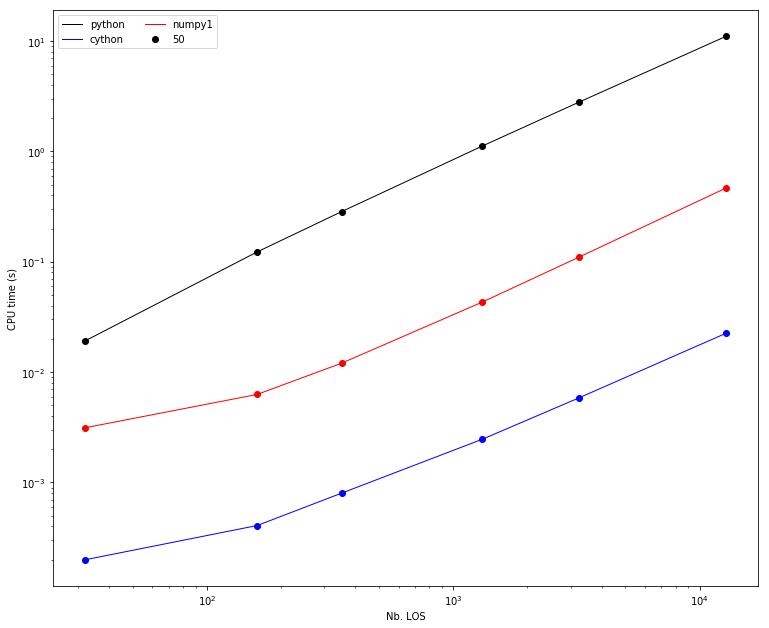

In [32]:
import datetime as dtm

######################################## (to be edited)
# Dictionnary of functions to be tested (add key to add a function)
Tests = {'python':{'func':Calc_LOS_PInOut_python, 'c':'k'},
         'numpy1':{'func':Calc_LOS_PInOut_numpy1, 'c':'r'},
         'cython':{'func':Calc_LOS_PInOut_cython, 'c':'b'}}

######################################## (can be edited)
# Parameters of the benchmark

# Number of segments constituting the vessel polygon 
# (i.e.: the polygon representing the cross-section of the toroial vessel) 
LS = [50]#[50,200]#,500]

# Number of Lines of Sight for which the function should be run
#, (i.e.: semi-lines)
LL = [1,4,10,40,100,400]#,100000,400000]
NS, NL = len(LS), len(LL)

# Number of times each function is executed (average and standard deviation are computed)
NRepeat = 6

######################################## (no editing)
# Benchmark and plot

Keys = Tests.keys()
for kk in range(len(Keys)):
    Tests[Keys[kk]]['t'] = np.nan*np.ones((NS,NL))
    Tests[Keys[kk]]['check'] = dict([(nn,np.zeros((NS,NL),dtype=bool)) for nn in ['SIn','SOut','VPerp','indOut']])

# Compute execution times
LSr, LLr = [], []
for ii in range(NS):
    VPoly = np.ascontiguousarray(makeVesPoly(LS[ii]))
    vIn = np.array([-(VPoly[1,1:]-VPoly[1,:-1]), VPoly[0,1:]-VPoly[0,:-1]])
    vIn = np.ascontiguousarray(vIn/np.tile(np.sqrt(np.sum(vIn**2,axis=0)),(2,1)))
    LSr.append(vIn.shape[1])
    print("")
    print("LS = "+str(LS[ii]))
    for jj in range(NL):
        Ds, us = makeLOS(LL[jj])
        Ds = np.ascontiguousarray(Ds)
        us = np.ascontiguousarray(us)
        if ii==0:
            LLr.append(Ds.shape[1])
        print("    LL = "+str(LL[jj]))
        for kk in range(len(Keys)):
            t = []
            for tt in range(NRepeat):
                t0 = dtm.datetime.now()
                SIn, SOut, VPerp, indOut = Tests[Keys[kk]]['func'](Ds, us, VPoly, vIn)
                t.append( (dtm.datetime.now()-t0).total_seconds() )
                if tt==NRepeat-1:
                        SIn0, SOut0, VPerp0, indOut0 = SIn, SOut, VPerp, indOut
            
            Tests[Keys[kk]]['t'][ii,jj] = np.median(t)
            Str = "        "+Keys[kk]+" "+str(np.median(t))+" / "+str(np.std(t))
            if kk>0:
                Tests[Keys[kk]]['check']['SIn'][ii,jj] = np.allclose(SIn,SIn0,atol=1.e-9,rtol=0.,equal_nan=True)
                Tests[Keys[kk]]['check']['SOut'][ii,jj] = np.allclose(SOut,SOut0,atol=1.e-9,rtol=0.,equal_nan=True)
                Tests[Keys[kk]]['check']['VPerp'][ii,jj] = np.allclose(VPerp,VPerp0,atol=1.e-9,rtol=0.,equal_nan=True)
                Tests[Keys[kk]]['check']['indOut'][ii,jj] = np.allclose(indOut,indOut0,atol=1.e-9,rtol=0.,equal_nan=True)
                Tests[Keys[kk]]['check']['vs'] = Keys[kk-1]
                allok = all([Tests[Keys[kk]]['check'][cc][ii,jj] for cc in ['SIn','SOut','VPerp','indOut']])
                Str += "   "+str(allok)+" vs "+Keys[kk-1]
            print(Str)
        
# Plot results  
f = plt.figure(figsize=(14,10),facecolor='w')
ax = f.add_axes([0.1,0.1,0.7,0.8], frameon=True,xscale='log',yscale='log')
ax.set_xlabel(r"Nb. LOS")
ax.set_ylabel(r"CPU time (s)")
m = ['o','x','^','+','s']
for kk in range(len(Keys)):
    for ii in range(NS):
        ax.plot(LLr, Tests[Keys[kk]]['t'][ii,:], ls='-', lw=1., c=Tests[Keys[kk]]['c'], marker=m[ii])

# Legend proxys
for kk in range(len(Keys)):
    ax.plot([],[], ls='-',lw=1.,c=Tests[Keys[kk]]['c'],label=Keys[kk])
for ii in range(NS):
    ax.plot([],[],ls='None',lw=0.,c='k',marker=m[ii], label="{0}".format(LS[ii]))
        
        
ax.legend(loc="upper left", ncol=2)
        
plt.show()



In [130]:
plt.gcf().savefig('./Fig_IPyNb_Stats_Cython_Last.png')

# Debug special cases

In [6]:
VPoly = np.array([[ 1.26499999,  1.26499999,  1.60800004 , 1.68299997,  1.63100004 , 1.57799995 ,                                                               
   1.59300005  ,1.62600005,  2.00600004,  2.23300004  ,2.2349999  , 2.26300001 ,                                                               
   2.2980001 ,  2.31599998 , 2.31599998 , 2.2980001 ,  2.26300001 , 2.2349999,                                                                 
   2.23300004  ,2.00600004 , 1.62600005 , 1.59300005  ,1.57799995 , 1.63100004   ,                                                             
   1.68299997  ,1.60800004 , 1.26499999]    ,                                                                                               
 [ 1.08500004, -1.08500004, -1.42900002, -1.43099999, -1.32599997, -1.32000005 ,                                                               
  -1.153  ,    -1.09000003, -0.773   ,   -0.44400001 ,-0.36899999 ,-0.31  ,     -0.189 ,                                                        
  -0.062   ,    0.062     ,  0.189  ,     0.31       , 0.36899999 , 0.44400001   ,                                                             
   0.773   ,    1.09000003 , 1.153   ,    1.32000005 , 1.32599997 , 1.43099999  ,                                                              
   1.42900002 , 1.08500004]])

VIn = np.array([[ 1. ,         0.70813522 , 0.02665687, -0.89612787 ,-0.1124874 , -0.99599034   ,                                                             
  -0.88583147, -0.64058188 ,-0.82309181, -0.99964469, -0.90342508, -0.96061987  ,                                                              
  -0.99010493, -1.         ,-0.99010493, -0.96061987, -0.90342508, -0.99964469   ,                                                             
  -0.82309181 ,-0.64058188 ,-0.88583147, -0.99599034, -0.1124874 , -0.89612787  ,                                                              
   0.02665687 , 0.70813522]   ,                                                                                                            
 [ 0.       ,   0.70607684 , 0.99964464, -0.44379595, -0.99365315,  0.08946081   ,                                                             
   0.46400713 , 0.76788987 , 0.56790833,  0.02665525,  0.42874599 , 0.27786592  ,                                                              
   0.14032896 , 0.        , -0.14032896, -0.27786592 ,-0.42874599, -0.02665525  ,                                                              
  -0.56790833 ,-0.76788987, -0.46400713, -0.08946081,  0.99365315 , 0.44379595 ,                                                               
  -0.99964464 ,-0.70607684]])

#Ds =np.array([[6.098],[-0.03115],[0.134175]])
Ds = np.array([[6.098],[-0.03115],[0.134175]])

#dus = np.array([[-9.85837500e-01],[1.67701586e-01],[-7.75785190e-04]])
dus = np.array([[-9.86046458e-01],[1.66470367e-01],[5.86903767e-09]])


In [15]:
SInn, SOutn, VPerpn, indOutn = Calc_LOS_PInOut_numpy1(Ds, dus, VPoly, VIn)
SInc, SOutc, VPerpc, indOutc = Calc_LOS_PInOut_cython(Ds, dus, VPoly, VIn)
SInf, SOutf = Calc_LOS_PInOut_Multi_Flat(Ds, dus, VPoly, VIn)

A [ 5.22365342  3.93303256] [ 0 14] [ 0.43816821  0.56830709] [ 1.60022497  5.31657769] [ 0.79444343  2.08506429]
A [ 6.81254028  8.10316114] [ 0 14] [ 0.43816821  0.56830709]
B [] []
C [] [] [] [] []
C [] [] [] [] []
1 5.22365341838
2 3.93303256252
Crit [  5.00000000e-08   5.00000000e-08   5.00000000e-08   5.00000000e-08
   5.00000000e-08   5.00000000e-08   5.00000000e-08   5.00000000e-08
   5.00000000e-08   5.00000000e-08   5.00000000e-08   5.00000000e-08
   5.00000000e-08   5.00000000e-08   5.00000000e-08   5.00000000e-08
   5.00000000e-08   5.00000000e-08   5.00000000e-08   5.00000000e-08
   5.00000000e-08   5.00000000e-08   5.00000000e-08   5.00000000e-08
   5.00000000e-08   5.00000000e-08] [  5.86903767e-09   5.86903767e-09   5.86903767e-09   5.86903767e-09
   5.86903767e-09   5.86903767e-09   5.86903767e-09   5.86903767e-09
   5.86903767e-09   5.86903767e-09   5.86903767e-09   5.86903767e-09
   5.86903767e-09   5.86903767e-09   5.86903767e-09   5.86903767e-09
   5.86903767e-09  

/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:120: RuntimeWarning: invalid value encountered in less
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:120: RuntimeWarning: invalid value encountered in greater
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:121: RuntimeWarning: invalid value encountered in less
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:121: RuntimeWarning: invalid value encountered in greater
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Applications/Anaconda/python27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [156]:
print "RIn", np.hypot(SInn[0,:],SInn[1,:]), np.hypot(SInc[0,:],SInc[1,:]), np.hypot(SInf[0,:],SInf[1,:])
print "ROut", np.hypot(SOutn[0,:],SOutn[1,:]), np.hypot(SOutc[0,:],SOutc[1,:]), np.hypot(SOutf[0,:],SOutf[1,:])

for (A,B,C) in [(SInn,SInc,SInf),(SOutn,SOutc,SOutf),(VPerpn,VPerpc,np.array([0])),(indOutn,indOutc,np.array([0]))]:
    print ""
    print A.flatten()
    print B.flatten()
    print C.flatten()

RIn [ 2.30577052] [ 2.30577052] [ 2.30577052]
ROut [ 1.26499999] [ 1.26499999] [ 1.26499999]

[ 2.21984717  0.62358337  0.13417502]
[ 2.21984717  0.62358337  0.13417502]
[ 2.21984717  0.62358337  0.13417502]

[ 0.94723505  0.8384335   0.13417503]
[ 0.94723505  0.8384335   0.13417503]
[ 0.94723505  0.8384335   0.13417503]

[ 0.74880242  0.66279329  0.        ]
[ 0.74880242  0.66279329  0.        ]
[0]

[ 0.]
[ 0.]
[0]


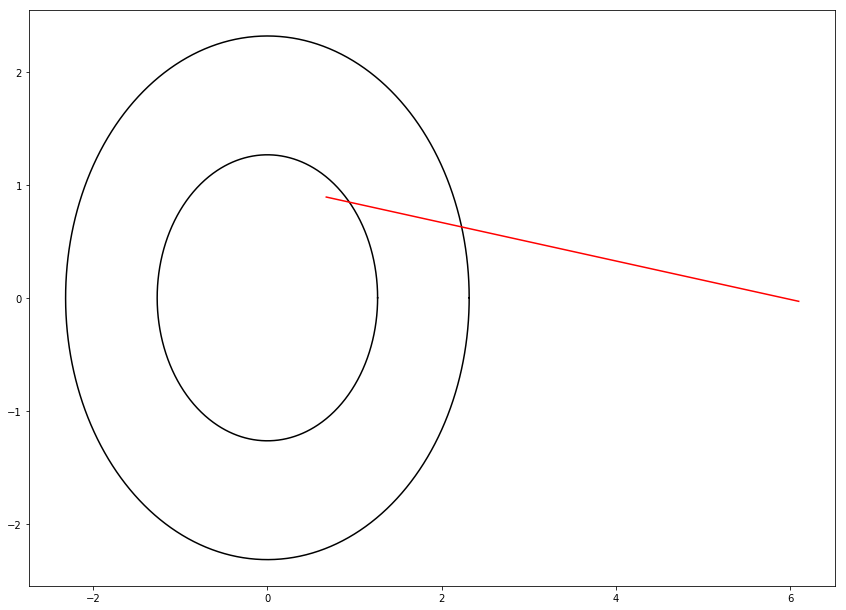

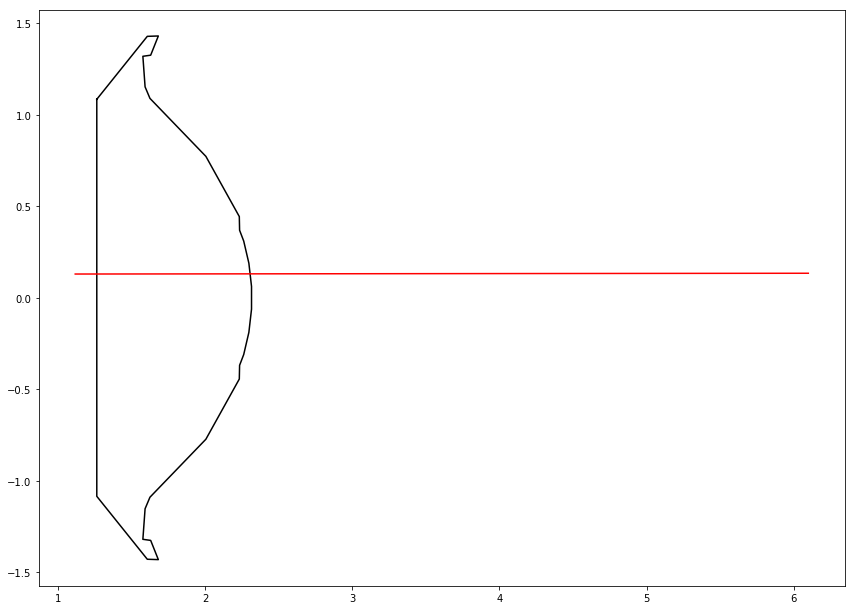

In [140]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(14,10))
ax = f.add_axes([0.1,0.1,0.8,0.8])
the = np.linspace(0.,2.*np.pi,1000)
ax.plot(np.nanmin(VPoly[0,:])*np.cos(the), np.nanmin(VPoly[0,:])*np.sin(the),'-k')
ax.plot(np.nanmax(VPoly[0,:])*np.cos(the), np.nanmax(VPoly[0,:])*np.sin(the),'-k')
k = 5.5
ax.plot([Ds[0,0],Ds[0,0]+k*dus[0,0]],[Ds[1,0],Ds[1,0]+k*dus[1,0]], '-r')

f = plt.figure(figsize=(14,10))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax.plot(VPoly[0,:],VPoly[1,:],'-k')
k = 5.5
ax.plot([np.hypot(Ds[0,0],Ds[1,0]),np.hypot(Ds[0,0]+k*dus[0,0],Ds[1,0]+k*dus[1,0])],[Ds[2,0],Ds[2,0]+k*dus[2,0]], '-r')

plt.show()

In [14]:
%%cython
import numpy as np
cimport numpy as np
import math
#from matplotlib.path import Path
import Polygon as plg
import scipy.integrate as scpinteg
import warnings
cimport cython
import datetime as dtm


ctypedef np.float_t DTYPE_t

def Calc_LOS_PInOut_Multi_Flat(np.ndarray[DTYPE_t, ndim=2] Ds, np.ndarray[DTYPE_t, ndim=2] dus,
                                np.ndarray[DTYPE_t, ndim=2,mode='c'] VPoly, np.ndarray[DTYPE_t, ndim=2,mode='c'] vIn,
                                RMin=None, Margin=0.1, Forbid=True, EpsUz=1.e-6, EpsVz=1.e-9, EpsA=1.e-9, EpsB=1.e-9):

    # Pre-define useful quantities
    Cs, vs = VPoly[:,:-1], VPoly[:,1:]-VPoly[:,:-1]
    upscaDp = dus[0,:]*Ds[0,:] + dus[1,:]*Ds[1,:]
    upar2 = dus[0,:]**2 + dus[1,:]**2
    Dpar2 = Ds[0,:]**2 + Ds[1,:]**2
    NL, NS, MaxErr = Ds.shape[1], vIn.shape[1], 20.

    DsF, dusF = np.repeat(Ds,NS,axis=1), np.repeat(dus,NS,axis=1)
    dus2 = dusF[2,:]
    Cs0, Cs1 = np.tile(Cs[0,:],NL), np.tile(Cs[1,:],NL)
    vs0, vs1 = np.tile(vs[0,:],NL), np.tile(vs[1,:],NL)
    upscaDpF, upar2F, Dpar2F = np.repeat(upscaDp,NS), np.repeat(upar2,NS), np.repeat(Dpar2,NS)
    #indL = np.repeat(np.arange(0,NL),NS)
    #indS = np.tile(np.arange(0,NS),NL)


    ########################
    # Find all intersections
    ########################

    ###########################
    # Start with horizontal LOS

    # Prepare arrays
    k0, k1 = np.nan*np.ones((NL*NS,)), np.nan*np.ones((NL*NS,))

    Crit = EpsUz*np.sqrt(upar2F)/MaxErr
    # Compute quasi-horizontal LOS
    ind01 = np.abs(dus2) < Crit      # Consider quasi-horizontal cases to avoid near-zero divisions otherwise, EpsUz is the tolerated DZ across 50m (max Tokamak size)
    ind01[ind01] = np.abs(vs1[ind01])>EpsVz
    q = (DsF[2,ind01]-Cs1[ind01])/vs1[ind01]
    ii = (q>=0) & (q<1)
    ind01[ind01], q = ii, q[ii]
    ind01 = ind01.nonzero()[0]
    C = q**2*vs0[ind01]**2 + 2.*q*Cs0[ind01]*vs0[ind01] + Cs0[ind01]**2
    delta = upscaDpF[ind01]**2 - upar2F[ind01]*(Dpar2F[ind01]-C)
    delta[delta<=0.] = np.nan
    sqd = np.sqrt(delta)
    k0[ind01] = (-upscaDpF[ind01] - sqd)/upar2F[ind01]
    k1[ind01] = (-upscaDpF[ind01] + sqd)/upar2F[ind01]
    del q, C, delta, sqd

    # Compute general cases
    A = vs0**2 - upar2F*(vs1/dus2)**2
    B = Cs0*vs0 + vs1*(DsF[2,:]-Cs1)*upar2F/dus2**2 - upscaDpF*vs1/dus2
    C = -upar2F*(DsF[2,:]-Cs1)**2/dus2**2 + 2.*upscaDpF*(DsF[2,:]-Cs1)/dus2 - Dpar2F + Cs0**2

    ind1 = (np.abs(dus2) > Crit) & (np.abs(A)<EpsA) & (np.abs(B)>EpsB)
    q = -C[ind1]/(2.*B[ind1])
    ii = (q>=0) & (q<1)
    ind1[ind1], q = ii, q[ii]
    ind1 = ind1.nonzero()[0]
    k0[ind1] = (q*vs1[ind1] - (DsF[2,ind1]-Cs1[ind1]))/dus2[ind1]
    del q, upscaDpF, upar2F, Dpar2F

    print "Crit", Crit, np.abs(dus2), (np.abs(dus2) > Crit), (np.abs(A)>EpsA), (B**2>A*C)
    ind21 = (np.abs(dus2) > Crit) & (np.abs(A)>EpsA) & (B**2>A*C)
    ind22 = np.copy(ind21)
    sqd = np.sqrt(B[ind21]**2-A[ind21]*C[ind21])
    q1 = (-B[ind21] + sqd)/A[ind21]
    q2 = (-B[ind21] - sqd)/A[ind21]
    print "sqd", sqd
    print "q1", q1
    ii = (q1>=0) & (q1<1.)
    ind21[ind21], q1 = ii, q1[ii]
    ii = (q2>=0) & (q2<1.)
    ind22[ind22], q2 = ii, q2[ii]
    ind21, ind22 = ind21.nonzero()[0], ind22.nonzero()[0]
    k0[ind21] = (q1*vs1[ind21] - (DsF[2,ind21]-Cs1[ind21]))/dus2[ind21]
    k1[ind22] = (q2*vs1[ind22] - (DsF[2,ind22]-Cs1[ind22]))/dus2[ind22]
    print B**2, A*C, q1
    print k0
    del A, B, C, sqd, q1, q2, Cs0, Cs1, vs0, vs1

    # Keep only k>0
    k0[k0<0.] = np.nan
    k1[k1<0.] = np.nan
    Ind0, Ind1 = ~np.isnan(k0), ~np.isnan(k1)
    Ind0n, Ind1n = Ind0.nonzero()[0], Ind1.nonzero()[0]

    # Compute associated solutions
    S0 = DsF[:,Ind0n] + k0[np.newaxis,Ind0n]*dusF[:,Ind0n]
    S1 = DsF[:,Ind1n] + k1[np.newaxis,Ind1n]*dusF[:,Ind1n]

    # Eliminate solution in forbidden area
    RMin = 0.95*min(np.nanmin(VPoly[0,:]), np.nanmin(np.hypot(Ds[0,:],Ds[1,:]))) if RMin is None else RMin
    RMax = 1.05*np.nanmax(VPoly[0,:])
    ZMin, ZMax = np.nanmin(VPoly[1,:])-0.05*np.abs(np.nanmin(VPoly[1,:])), np.nanmax(VPoly[1,:])+0.05*np.abs(np.nanmax(VPoly[1,:]))
    RS0, RS1 = np.hypot(S0[0,:],S0[1,:]), np.hypot(S1[0,:],S1[1,:])

    inderr0 = (RS0<RMin) | (RS0>RMax)
    inderr1 = (RS1<RMin) | (RS1>RMax)
    if not (inderr0.sum()==0 and inderr1.sum()==0):
        print "Identified problem"
        print "VPoly"
        print VPoly
        print "vIn"
        print vIn
        print "Ds"
        print DsF[:,Ind0n[inderr0 | inderr1]]
        print "us"
        print dusF[:,Ind1n[inderr0 | inderr1]]


    assert inderr0.sum()==0 and inderr1.sum()==0, "Some solutions ({0} in S0 and {1} in S1) are way too far({2})/close({3}) !".format(inderr0.sum(),inderr1.sum(),RMax,RMin)+str(RS0)+" "+str(RS1)+"  "+str(k0[Ind0n])+"  "+str(k1[Ind1n])
    inderr0 = (S0[2,:]<ZMin) | (S0[2,:]>ZMax)
    inderr1 = (S1[2,:]<ZMin) | (S1[2,:]>ZMax)
    assert inderr0.sum()==0 and inderr1.sum()==0, "Some solutions ({0} in S0 and {1} in S1) are way too high({0})/low({1}) !".format(inderr0.sum(),inderr1.sum(),ZMax,ZMin)+str(S0[2,:])+"  "+str(S1[2,:])

    if Forbid:
        # This criterion is the same for both solution k0 and k1
        Ind = Ind0 | Ind1
        Indr0, Indr1 = Ind0[Ind].nonzero()[0], Ind1[Ind].nonzero()[0]
        # Add a little bit of margin to the major radius, just in case
        R = np.hypot(DsF[0,Ind],DsF[1,Ind])*(1.+Margin*RMin)
        L = np.sqrt(R**2-RMin**2)
        # Compute new (X,Y) coordinates with the margin
        X = R * np.cos(np.arctan2(DsF[1,Ind],DsF[0,Ind]))
        Y = R * np.sin(np.arctan2(DsF[1,Ind],DsF[0,Ind]))
        # Compute coordinates of the 2 points where the tangents touch the inner circle
        S1X, S1Y = (RMin**2*X+RMin*Y*L)/R**2, (RMin**2*Y-RMin*X*L)/R**2
        S2X, S2Y = (RMin**2*X-RMin*Y*L)/R**2, (RMin**2*Y+RMin*X*L)/R**2
        # Check solutions are on the good side of the 3 planes
        indout = ((S0[0,:]-S1X[Indr0])*X[Indr0] + (S0[1,:]-S1Y[Indr0])*Y[Indr0] < 0.) & ((S0[0,:]-S1X[Indr0])*S1X[Indr0] + (S0[1,:]-S1Y[Indr0])*S1Y[Indr0] < 0.) & ((S0[0,:]-S2X[Indr0])*S2X[Indr0] + (S0[1,:]-S2Y[Indr0])*S2Y[Indr0] < 0.)
        k0[Ind0n[indout]] = np.nan
        S0 = np.delete(S0,indout.nonzero()[0],1)
        indout = ((S1[0,:]-S1X[Indr1])*X[Indr1] + (S1[1,:]-S1Y[Indr1])*Y[Indr1] < 0.) & ((S1[0,:]-S1X[Indr1])*S1X[Indr1] + (S1[1,:]-S1Y[Indr1])*S1Y[Indr1] < 0.) & ((S1[0,:]-S2X[Indr1])*S2X[Indr1] + (S1[1,:]-S2Y[Indr1])*S2Y[Indr1] < 0.)
        k1[Ind1n[indout]] = np.nan
        S1 = np.delete(S1,indout.nonzero()[0],1)
        Ind0, Ind1 = ~np.isnan(k0), ~np.isnan(k1)
        Ind0n, Ind1n = Ind0.nonzero()[0], Ind1.nonzero()[0]
        del Ind, Indr0, Indr1, R, L, X, Y, S1X, S1Y, S2X, S2Y, indout

    # Identify the POut (if any) and PIn (if any)
    VInF = np.tile(vIn,NL)
    Ang0, Ang1 = np.arctan2(S0[1,:],S0[0,:]), np.arctan2(S1[1,:],S1[0,:])
    sca0 = np.sum( dusF[:,Ind0n]*np.repeat(VInF[:,Ind0n],[2,1],axis=0)*np.array([np.cos(Ang0),np.sin(Ang0),np.ones((Ind0n.size,))]), axis=0)
    sca1 = np.sum( dusF[:,Ind1n]*np.repeat(VInF[:,Ind1n],[2,1],axis=0)*np.array([np.cos(Ang1),np.sin(Ang1),np.ones((Ind1n.size,))]), axis=0)

    # POut is the lowest k with sca<0
    indio0, indio1 = sca0<0., sca1<0.
    kio = np.nan*np.ones((2,NL*NS,))
    kio[0,Ind0n[indio0]] = k0[Ind0n[indio0]]
    kio[1,Ind1n[indio1]] = k1[Ind1n[indio1]]

    kio = np.nanmin(kio,axis=0).reshape((NL,NS))
    kout = np.nanmin(kio,axis=1)
    indnonan = ~np.isnan(kout)
    Ind = np.nan*np.ones((NL,))
    Ind[indnonan] = np.nanargmin(kio[indnonan,:],axis=1)
    SOut = Ds + kout[np.newaxis,:]*dus

    # Pin, if any, is the lowest k > kout with sca>0
    indio0, indio1 = sca0>0., sca1>0.
    kio = np.nan*np.ones((2,NL*NS,))
    kio[0,Ind0n[indio0]] = k0[Ind0n[indio0]]
    kio[1,Ind1n[indio1]] = k1[Ind1n[indio1]]
    kio = np.nanmin(kio,axis=0)
    kio[kio>np.repeat(kout,NS)] = np.nan
    kin = np.nanmin(kio.reshape((NL,NS)),axis=1)
    SIn = Ds + kin[np.newaxis,:]*dus

    return SIn, SOut#, ImpVin, indFOut
    
    
    
